In [1]:
%load_ext autoreload
from ddls.plotting.plotting import plot_line, plot_bar, plot_hist, PlotAesthetics

from collections import defaultdict
from sqlitedict import SqliteDict
import pprint
import glob
import os
import time
import pandas as pd
import numpy as np
import scipy.stats as st
import sigfig

import gzip
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

In [143]:
# set paths to agent(s)

base_folder = '/scratch/datasets/ddls/sims/'

# base_name = 'job_placing'
# # ids = [108]
# ids = [108, 116]

# base_name = 'ramp_job_placement_shaping'
base_name = 'ramp_job_partitioning'
agent_to_id = {
    
    # 'Random': 349,
    # 'First Fit': 350,
    # 'Last Fit': 351,
    # # 'RL': f'{base_folder}/{base_name}/{base_name}_{348}/checkpoints/checkpoint_000002/',
    # 'RL': 363,
    
    # AlexNet
    # 'First Fit': 381,
    # 'RL': f'{base_folder}/{base_name}/{base_name}_{385}/checkpoints/checkpoint_000006/',
    
    # # 5 'small' graphs (image classification and NMT) -> 1000 in an episode (replication_factor=200)
    # 'First Fit': 441,
    # # 'RL': f'{base_folder}/{base_name}/{base_name}_{437}/checkpoints/checkpoint_000002/',
    
    
    
    
    # RAMP_JOB_PARTITIONING
    
    # # 200 AlexNet, max_partitions_per_op=None
    # 'Random': 64,
    # 'No\nPara': 78,
    # 'Max\nPara': 79,
    # 'SiP-ML': 67,
    # 'RL\n(JCT)': f'{base_folder}/{base_name}/{base_name}_{104}/checkpoints/checkpoint_000023/',
    # 'RL\n(Acc)': f'{base_folder}/{base_name}/{base_name}_{103}/checkpoints/checkpoint_000500/',
    
    # 20 small_graphs, max_partitions_per_op=8
    'Random': 302,
    'No\nPara': 303,
    'Max\nPara': 304,
    'SiP-ML': 305,
    'RL-cp-90': f'{base_folder}/{base_name}/{base_name}_{518}/checkpoints/checkpoint_000090/',
    'RL-cp-95': f'{base_folder}/{base_name}/{base_name}_{518}/checkpoints/checkpoint_000095/',
    # 'RL\n(JCT)': f'{base_folder}/{base_name}/{base_name}_{104}/checkpoints/checkpoint_000023/',
    # 'RL\n(Acc)': f'{base_folder}/{base_name}/{base_name}_{103}/checkpoints/checkpoint_000500/',
    
}

In [144]:
# load data

episode_metrics = {
    'num_jobs_arrived',
    'num_jobs_completed',
    'num_jobs_blocked',
    
    'mean_compute_throughput',
    'mean_comm_throughput',
    'mean_cluster_throughput',
    
    # 'return',
}

episode_completion_metrics = {
    'job_completion_time',
    'job_communication_overhead_time',
    'job_computation_overhead_time',
    'jobs_completed_num_nodes',
    'jobs_completed_num_edges',
    'jobs_completed_total_operation_memory_cost',
    'jobs_completed_total_dependency_size',
}

episode_blocked_metrics = {
    'jobs_blocked_num_nodes',
    'jobs_blocked_num_edges',
    'jobs_blocked_total_operation_memory_cost',
    'jobs_blocked_total_dependency_size',
}

# 'jobs_blocked_causes', # TODO: Process strings properly below when plotting
step_metrics = set()

agent_to_episode_stats_dict = defaultdict(list)
agent_to_episode_completion_stats_dict = defaultdict(list)
agent_to_episode_blocked_stats_dict = defaultdict(list)

agent_to_step_stats_dict = defaultdict(list)

for agent, _id in agent_to_id.items():
    if isinstance(_id, int):
        # use int id to generate string dir to data
        agent_dir = base_folder + f'{base_name}/{base_name}_{_id}/'
    else:
        # string dir to data already provided
        agent_dir = _id
    if os.path.isdir(agent_dir):
        print(f'\nLoading validation data from {agent_dir[:-1]}...')
            
        completion_stats_found, blocked_stats_found = False, False

        # load episode stats
        with gzip.open(agent_dir+'episode_stats.pkl', 'rb') as f:
            episode_stats = pickle.load(f)
        for metric, result in episode_stats.items():
            if metric in episode_metrics:
                try:
                    agent_to_episode_stats_dict[metric].extend(result)
                except TypeError:
                    agent_to_episode_stats_dict[metric].append(result)
            elif metric in episode_completion_metrics:
                completion_stats_found = True
                try:
                    agent_to_episode_completion_stats_dict[metric].extend(result)
                except TypeError:
                    agent_to_episode_completion_stats_dict[metric].append(result)
            elif metric in episode_blocked_metrics:
                blocked_stats_found = True
                try:
                    agent_to_episode_blocked_stats_dict[metric].extend(result)
                except TypeError:
                    agent_to_episode_blocked_stats_dict[metric].append(result)
            else:
                print(f'Unrecognised metric {metric}, skipping...')
        agent_to_episode_stats_dict['Agent'].append(agent)
        if completion_stats_found:
            agent_to_episode_completion_stats_dict['Agent'].append(agent)
        if blocked_stats_found:
            agent_to_episode_blocked_stats_dict['Agent'].append(agent)

        # load step stats
        with gzip.open(agent_dir+'step_stats.pkl', 'rb') as f:
            step_stats = pickle.load(f)
        for metric, result in step_stats.items():
            try:
                agent_to_step_stats_dict[metric].extend(result)
            except TypeError:
                agent_to_step_stats_dict[metric].append(result)
            step_metrics.add(metric)
        agent_to_step_stats_dict['Agent'].extend([agent for _ in range(len(result))])
        
        print(f'Checkpoints loaded from {agent_dir[:-1]}.')
    else:
        print(f'\nNo checkpoints/ folder found in {agent_dir[:-1]}')
       
print(f'\nEpisode stats:')
# print(agent_to_episode_stats_dict)
episode_stats_df = pd.DataFrame(agent_to_episode_stats_dict)
display(episode_stats_df)
# print(agent_to_episode_completion_stats_dict)
episode_completion_stats_df = pd.DataFrame(agent_to_episode_completion_stats_dict)
display(episode_completion_stats_df)
# print(agent_to_episode_blocked_stats_dict)
episode_blocked_stats_df = pd.DataFrame(agent_to_episode_blocked_stats_dict)
display(episode_blocked_stats_df)

print(f'\nStep stats:')
# print(agent_to_step_stats_dict)
# for key, val in agent_to_step_stats_dict.items():
#     print(f'{key} -> {len(val)} vals')
step_stats_df = pd.DataFrame(agent_to_step_stats_dict)
display(step_stats_df)


Loading validation data from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_302...
Checkpoints loaded from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_302.

Loading validation data from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_303...
Checkpoints loaded from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_303.

Loading validation data from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_304...
Checkpoints loaded from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_304.

Loading validation data from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_305...
Checkpoints loaded from /scratch/datasets/ddls/sims/ramp_job_partitioning/ramp_job_partitioning_305.

Loading validation data from /scratch/datasets/ddls/sims//ramp_job_partitioning/ramp_job_partitioning_518/checkpoints/checkpoint_000090...
Unrecognised metric 

,num_jobs_arrived,num_jobs_completed,num_jobs_blocked,mean_compute_throughput,mean_comm_throughput,mean_cluster_throughput,Agent
0,100.0,67.0,33.0,1.607988e+06,1.770505e+06,3.378493e+06,Random
1,100.0,96.0,4.0,1.057504e+06,1.143677e+06,2.201181e+06,No\nPara
2,100.0,46.0,54.0,4.110284e+06,1.782712e+07,2.193741e+07,Max\nPara
3,100.0,46.0,54.0,4.110284e+06,1.782712e+07,2.193741e+07,SiP-ML
4,100.0,47.0,53.0,2.700844e+06,1.130172e+07,1.400256e+07,RL-cp-90
5,100.0,42.0,58.0,8.855207e+06,3.925415e+07,4.810935e+07,RL-cp-95


,job_completion_time,job_communication_overhead_time,job_computation_overhead_time,jobs_completed_num_nodes,jobs_completed_num_edges,jobs_completed_total_operation_memory_cost,jobs_completed_total_dependency_size,Agent
0,19813.660259,19813.660259,19777.582224,201.850746,987.268657,1.471648e+10,2.544922e+10,Random
1,30358.132292,30358.132292,30358.132292,100.250000,111.500000,1.575630e+10,1.682224e+10,No\nPara
2,8275.875578,8275.875578,8026.553931,665.913043,6847.108696,1.629020e+10,6.946058e+10,Max\nPara
3,8275.875578,8275.875578,8026.553931,665.913043,6847.108696,1.629020e+10,6.946058e+10,SiP-ML
4,8016.460916,8016.460916,7723.077184,644.170213,6608.425532,1.764132e+10,7.525502e+10,RL-cp-90
5,8809.109606,8809.109606,8588.030717,690.904762,7081.238095,1.647027e+10,6.935809e+10,RL-cp-95


,jobs_blocked_num_nodes,jobs_blocked_num_edges,jobs_blocked_total_operation_memory_cost,jobs_blocked_total_dependency_size,Agent
0,106.303030,118.090909,1.755214e+10,1.808080e+10,Random
1,104.000000,119.000000,1.315521e+10,1.256399e+10,No\nPara
2,98.814815,110.555556,1.510882e+10,1.534519e+10,Max\nPara
3,98.814815,110.555556,1.510882e+10,1.534519e+10,SiP-ML
4,100.792453,112.962264,1.388837e+10,1.418055e+10,RL-cp-90
5,95.689655,106.413793,1.505989e+10,1.509693e+10,RL-cp-95



Step stats:


,action,reward,step_counter,step_start_time,mean_num_mounted_workers,mean_num_mounted_channels,mean_compute_throughput,mean_comm_throughput,mean_cluster_throughput,mean_compute_overhead_frac,...,num_jobs_completed,mean_num_jobs_running,num_jobs_arrived,num_jobs_blocked,compute_info_processed,comm_info_processed,cluster_info_processed,step_end_time,job_queue_length,Agent
0,2,0.000014,0,0.0,2.0,2.0,1.049633e+06,1.773791e+06,2.823424e+06,1.0,...,0,1.0,1,0,1.049633e+09,1.773791e+09,2.823424e+09,1000.000000,1,Random
1,8,0.000031,1,1000.0,10.0,58.0,1.664577e+06,4.443966e+06,6.108543e+06,1.0,...,0,2.0,1,0,1.664577e+09,4.443966e+09,6.108543e+09,2000.000000,1,Random
2,1,0.000037,2,2000.0,11.0,58.0,2.194336e+06,5.185826e+06,7.380162e+06,1.0,...,0,3.0,1,0,2.194336e+09,5.185826e+09,7.380162e+09,3000.000000,1,Random
3,1,0.000046,3,3000.0,12.0,58.0,3.081374e+06,6.071376e+06,9.152750e+06,1.0,...,0,4.0,1,0,3.081374e+09,6.071376e+09,9.152750e+09,4000.000000,1,Random
4,4,0.000046,4,4000.0,12.0,58.0,3.081374e+06,6.071376e+06,9.152750e+06,1.0,...,0,4.0,1,1,3.081374e+09,6.071376e+09,9.152750e+09,5000.000000,1,Random
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,8,0.000248,133,95000.0,24.5,168.0,9.083671e+06,3.915775e+07,4.824142e+07,1.0,...,1,3.5,1,0,9.068202e+09,3.909829e+10,4.816649e+10,96000.000000,1,RL-cp-95
596,8,0.000386,134,96000.0,32.0,224.0,1.432320e+07,6.270215e+07,7.702535e+07,1.0,...,0,4.0,1,0,1.432320e+10,6.270215e+10,7.702535e+10,97000.000000,1,RL-cp-95
597,0,0.000386,135,97000.0,32.0,224.0,1.432320e+07,6.270215e+07,7.702535e+07,1.0,...,0,4.0,1,1,1.432320e+10,6.270215e+10,7.702535e+10,98000.000000,1,RL-cp-95
598,0,0.000386,136,98000.0,32.0,224.0,1.432320e+07,6.270215e+07,7.702535e+07,1.0,...,0,4.0,1,1,1.432320e+10,6.270215e+10,7.702535e+10,99000.000000,1,RL-cp-95


In [145]:
aesthetics = PlotAesthetics()
aesthetics.set_icml_paper_plot_aesthetics() # paper training curve

estimator = np.mean # np.mean np.median

scaling_factor = 1
width_scaling_factor = 1
height_scaling_factor = 1

step_stats_xaxis = 'step_end_time'
step_stats_xaxis_label = 'Time (s)'

legend = 'auto'

ylog = False
xlog = False

ci = None
errcolor = 'gray'
capsize = 0.05


# display bar chart values
display_values = True
# display_values = False
y_offset = 0
# loc = 'bottom'
loc = 'top'




def show_values_on_bars(axs, sigfigs=2, y_offset=0, loc='top'):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            if loc == 'top':
                _x = p.get_x() + p.get_width() / 2
    #             _y = p.get_y() + p.get_height()
    #             _y = p.get_y() + y_offset
                _y = p.get_height() + y_offset
                value = sigfig.round(p.get_height(), sigfigs=sigfigs)
                ax.text(_x, _y, value, ha="center") 
            elif loc == 'bottom':
                _x = p.get_x() + p.get_width() / 2
    #             _y = p.get_y() + p.get_height()
                _y = p.get_y() + y_offset
                value = sigfig.round(p.get_height(), sigfigs=sigfigs)
                ax.text(_x, _y, value, ha="center") 
            else:
                raise Exception(f'Unrecognised loc {loc}')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def barplot(df, metric, x='Agent', display_values=True):
    print(f'Plotting metric {metric} -> min={np.min(df[metric])} | max={np.max(df[metric])} | mean={np.mean(df[metric])}')
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    g = sns.barplot(data=df,
                    x=x,
                    y=metric,
                    # order=order,
                    # palette=palette,
                    estimator=estimator,
                    ci=ci,
                    errcolor=errcolor,
                    capsize=capsize)
    g.set_xlabel('Agent')
    g.set_ylabel(metric)
    ax.tick_params(axis='both', which='major', pad=2)
    plt.xticks(fontsize=7.5)
    ax.xaxis.labelpad = 2
    # ax.xaxis.label.set_size(2)
    ax.yaxis.labelpad = 2
    sns.despine(ax=ax) # remove top and right spines
    if ylog:
        g.set(yscale='log')
    if xlog:
        g.set(xscale='log')
    if display_values:
        show_values_on_bars(ax, sigfigs=3, y_offset=y_offset, loc=loc)
    plt.gcf().patch.set_alpha(0.0)
    plt.show()
    
def lineplot(df, metric):
    print(f'Plotting metric {metric} -> min={np.min(df[metric])} | max={np.max(df[metric])} | mean={np.mean(df[metric])}')
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    g = sns.lineplot(data=df, 
                     x=step_stats_xaxis, 
                     y=metric, 
                     hue='Agent', 
                     linewidth=aesthetics.linewidth, 
                     legend=legend)
    # g = sns.scatterplot(data=episode_stats_df, x=xaxis, y=metric, hue='Agent', linewidth=aesthetics.linewidth, legend=legend)
    plt.title(metric)
    ax.tick_params(axis='both', which='major', pad=2)
    ax.xaxis.labelpad = 2
    ax.yaxis.labelpad = 2
    sns.despine(ax=ax) # remove top and right spines
    plt.gcf().patch.set_alpha(0.0)
    plt.show()



EPISODE METRICS
Plotting metric num_jobs_arrived -> min=100.0 | max=100.0 | mean=100.0


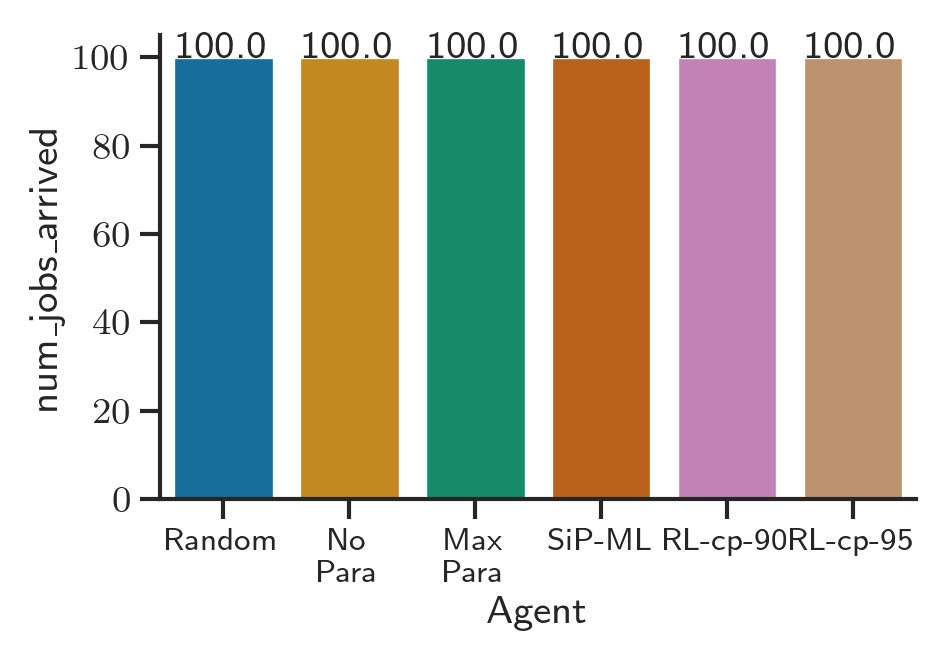

Plotting metric mean_cluster_throughput -> min=2201181.003810489 | max=48109352.4256234 | mean=18594400.357196588


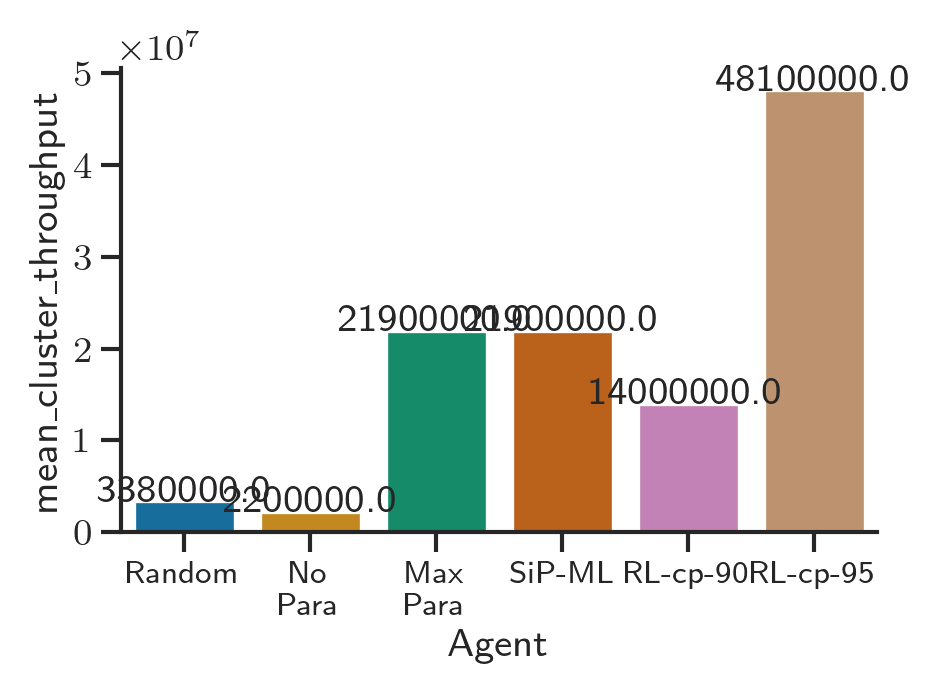

Plotting metric num_jobs_blocked -> min=4.0 | max=58.0 | mean=42.666666666666664


/scratch/zciccwf/py36/envs/ddls/lib/python3.9/site-packages/sigfig/sigfig.py:585: UserWarning: warning: 3 significant figures requested from number with only 2 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))


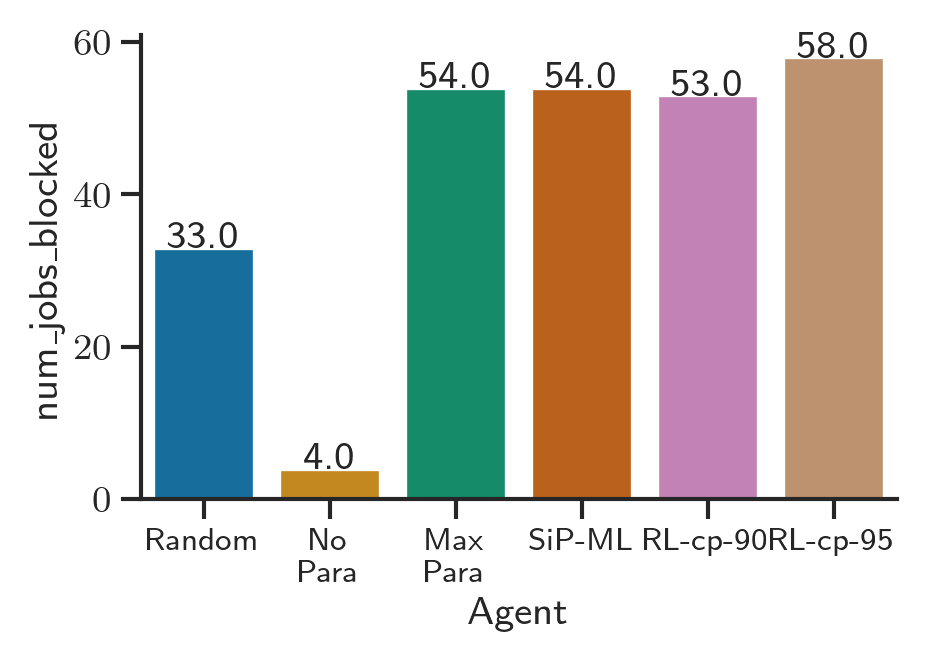

Plotting metric mean_compute_throughput -> min=1057504.2175970501 | max=8855206.768260218 | mean=3740351.8215402127


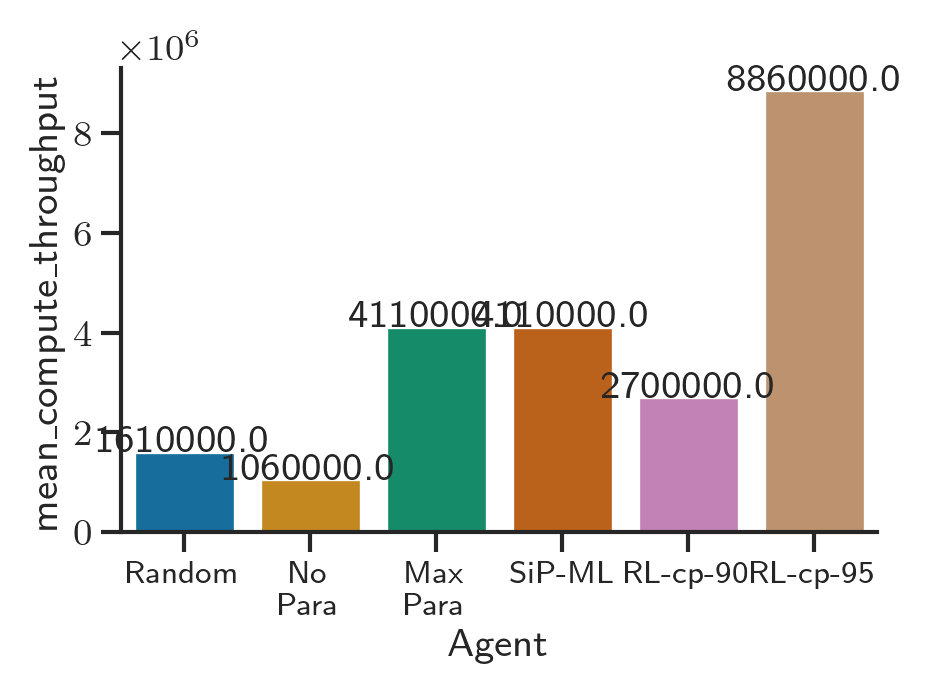

Plotting metric num_jobs_completed -> min=42.0 | max=96.0 | mean=57.333333333333336


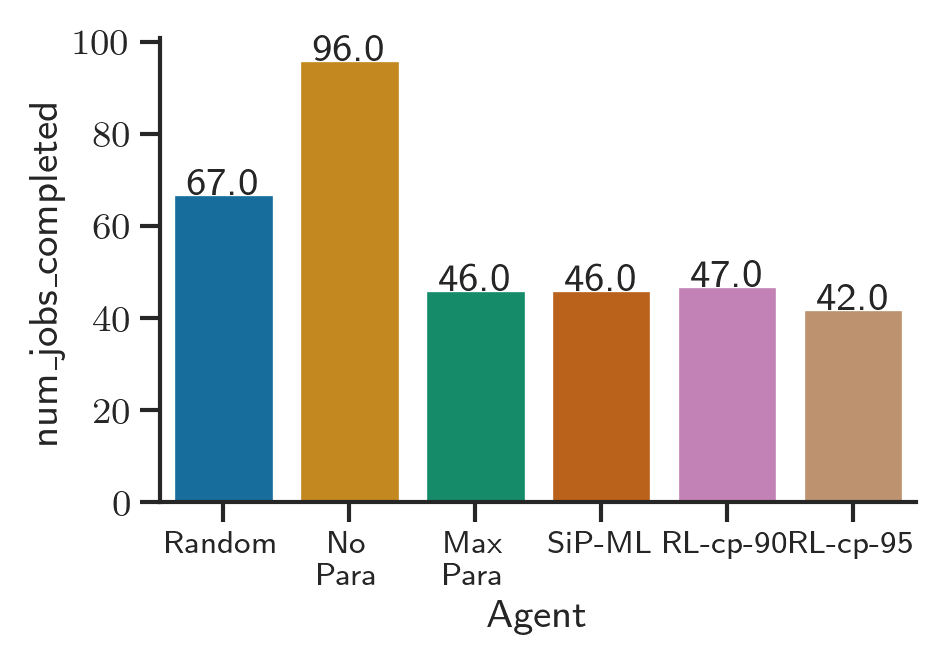

Plotting metric mean_comm_throughput -> min=1143676.786213439 | max=39254145.657363184 | mean=14854048.535656372


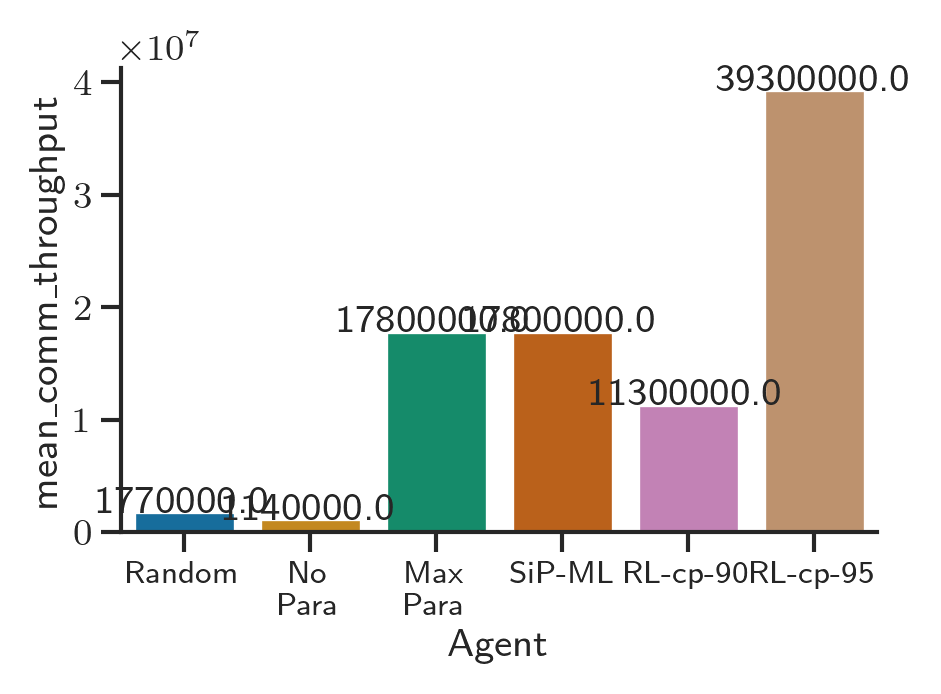

Plotting metric jobs_completed_num_edges -> min=111.5 | max=7081.238095238095 | mean=4747.108279195626


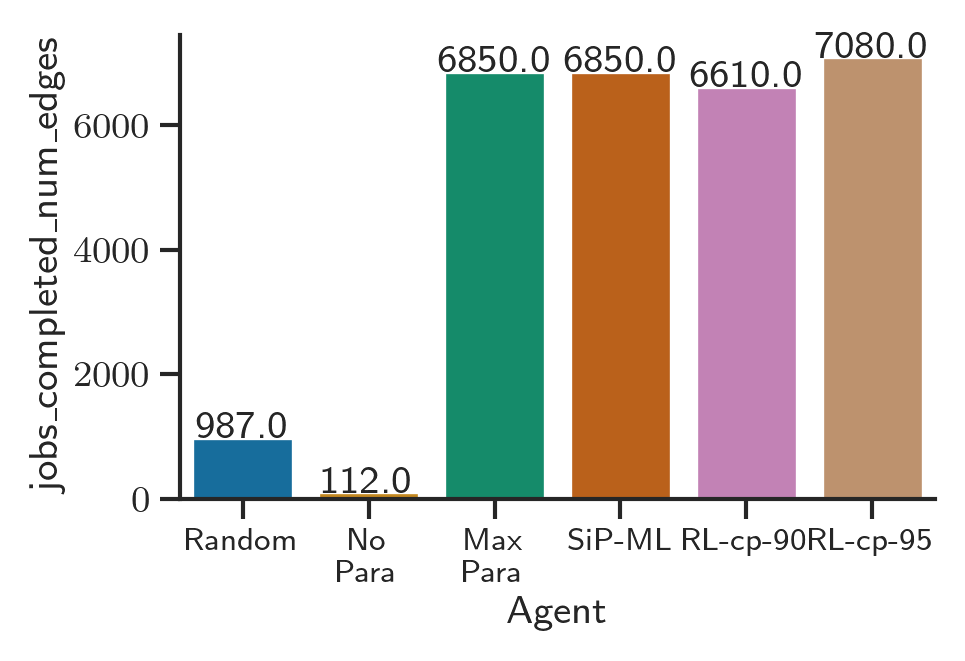

Plotting metric job_completion_time -> min=8016.460916330319 | max=30358.132291666672 | mean=13924.852371408073


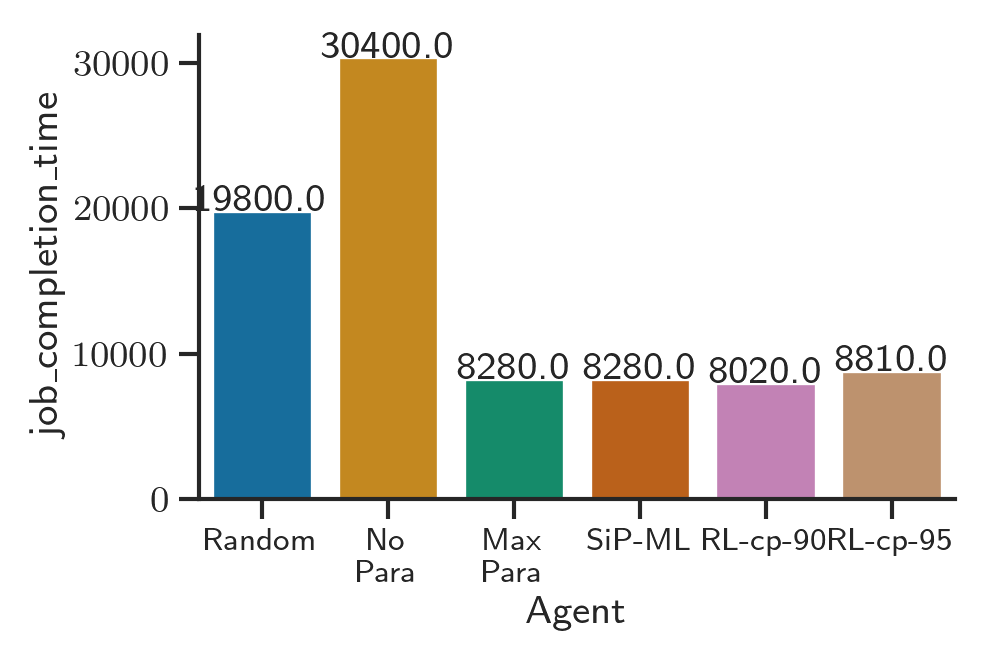

Plotting metric job_computation_overhead_time -> min=7723.077183551912 | max=30358.132291666672 | mean=13749.98837959047


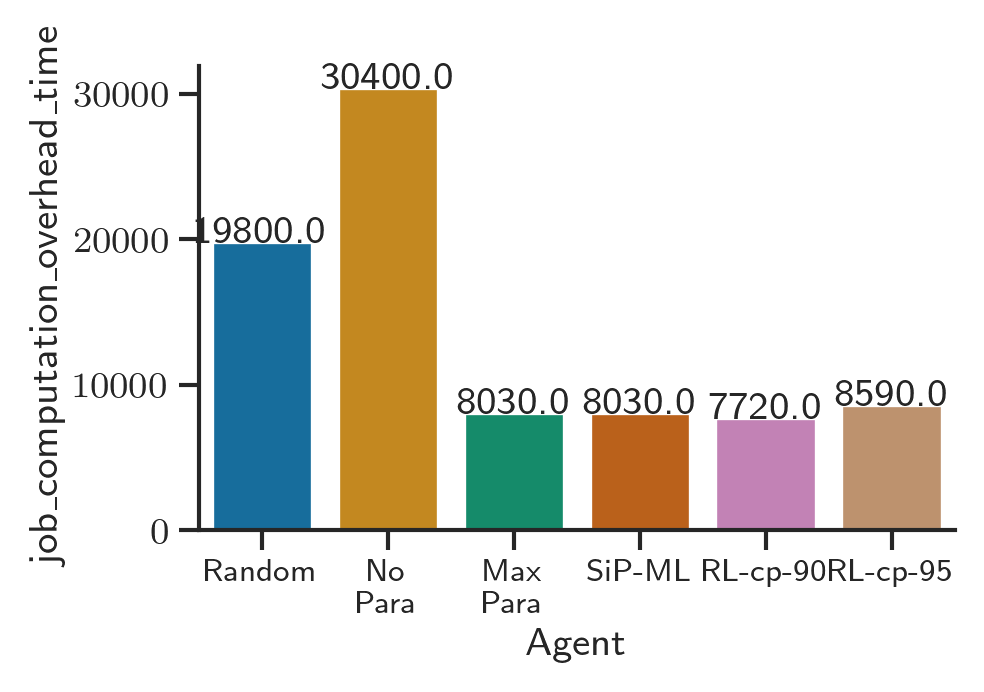

Plotting metric jobs_completed_total_operation_memory_cost -> min=14716484350.567163 | max=17641315142.638298 | mean=16194126684.382933


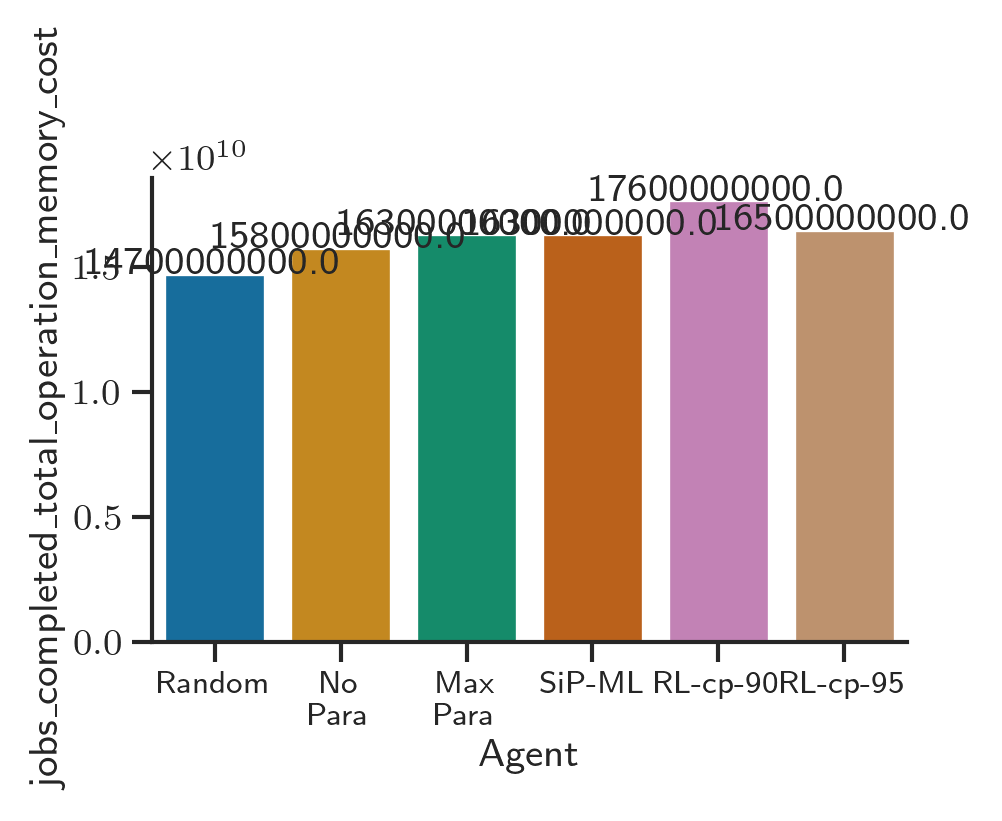

Plotting metric job_communication_overhead_time -> min=8016.460916330317 | max=30358.132291666672 | mean=13924.852371408067


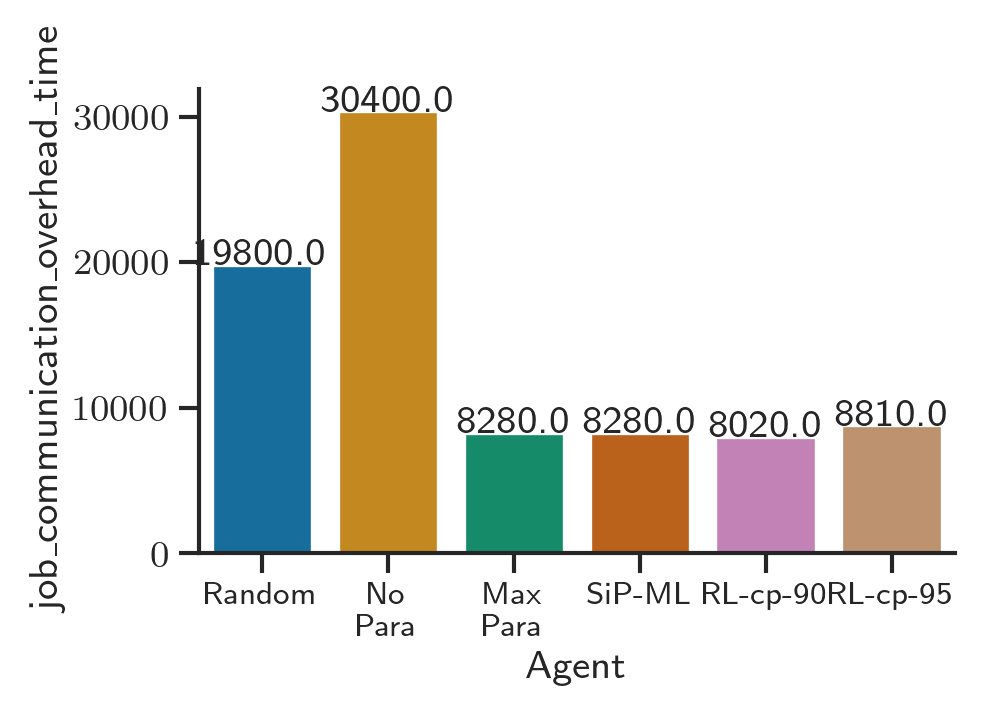

Plotting metric jobs_completed_total_dependency_size -> min=16822244053.166666 | max=75255019988.85106 | mean=54300957452.96549


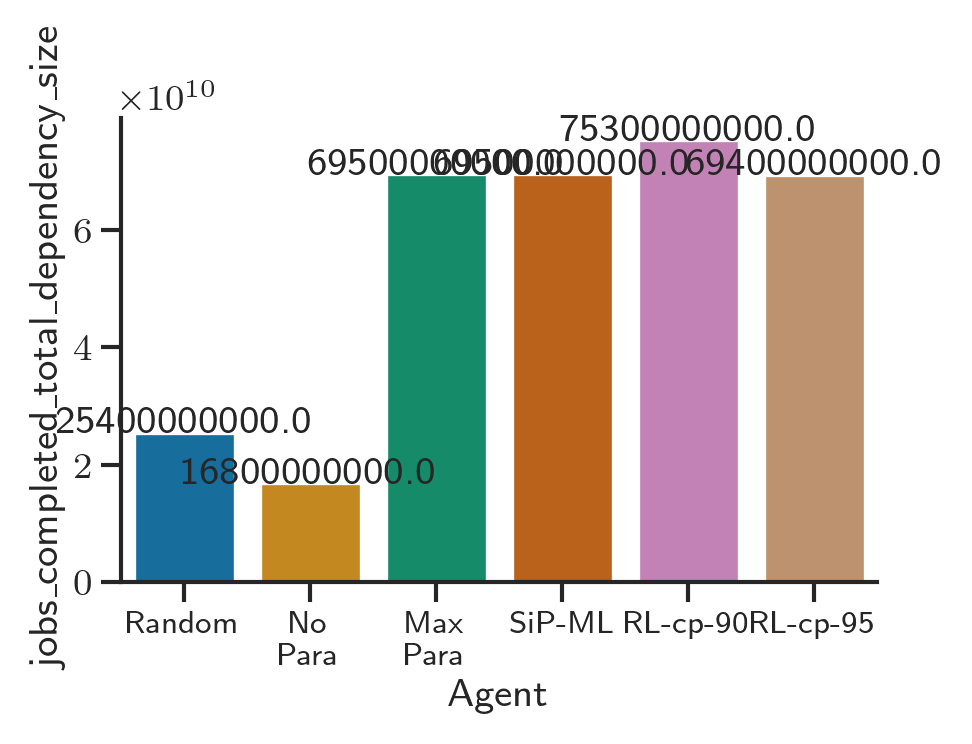

Plotting metric jobs_completed_num_nodes -> min=100.25 | max=690.9047619047619 | mean=494.8336346493163


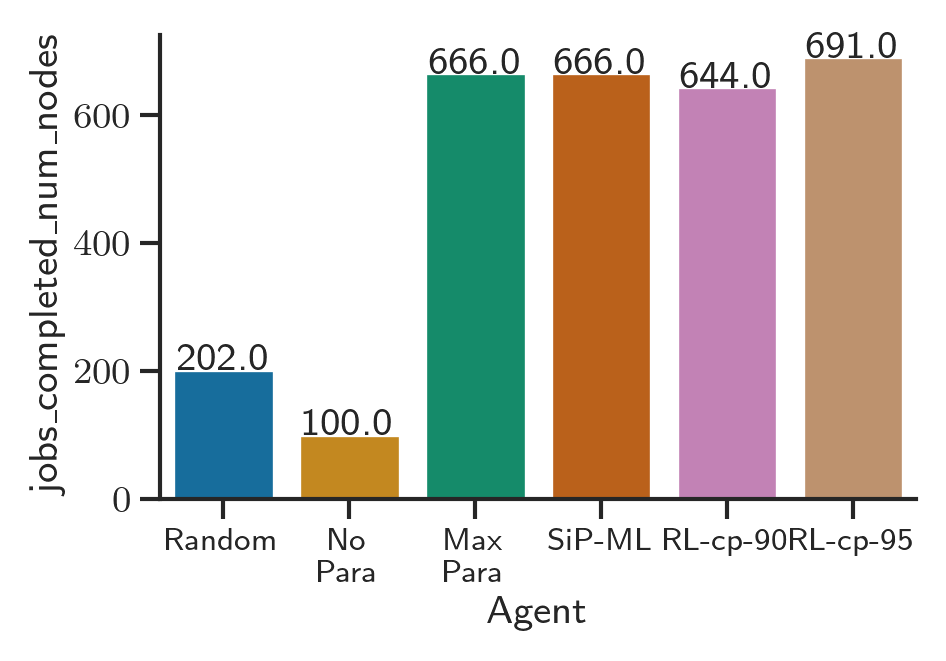

Plotting metric jobs_blocked_num_nodes -> min=95.6896551724138 | max=106.3030303030303 | mean=100.73579465587706


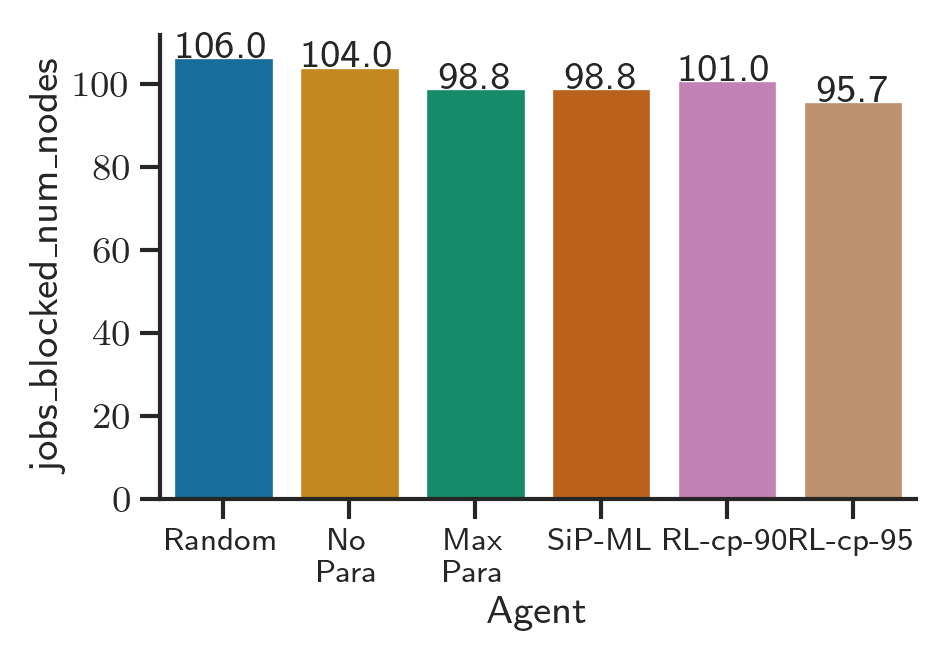

Plotting metric jobs_blocked_num_edges -> min=106.41379310344827 | max=119.0 | mean=112.92967957606864


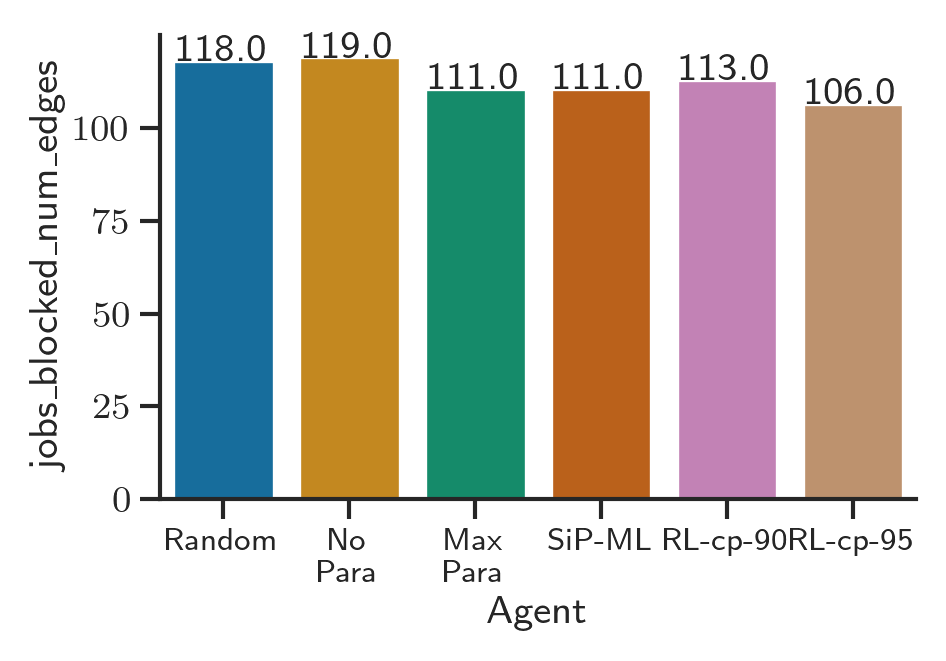

Plotting metric jobs_blocked_total_dependency_size -> min=12563986436.0 | max=18080795809.939392 | mean=15102105575.697256


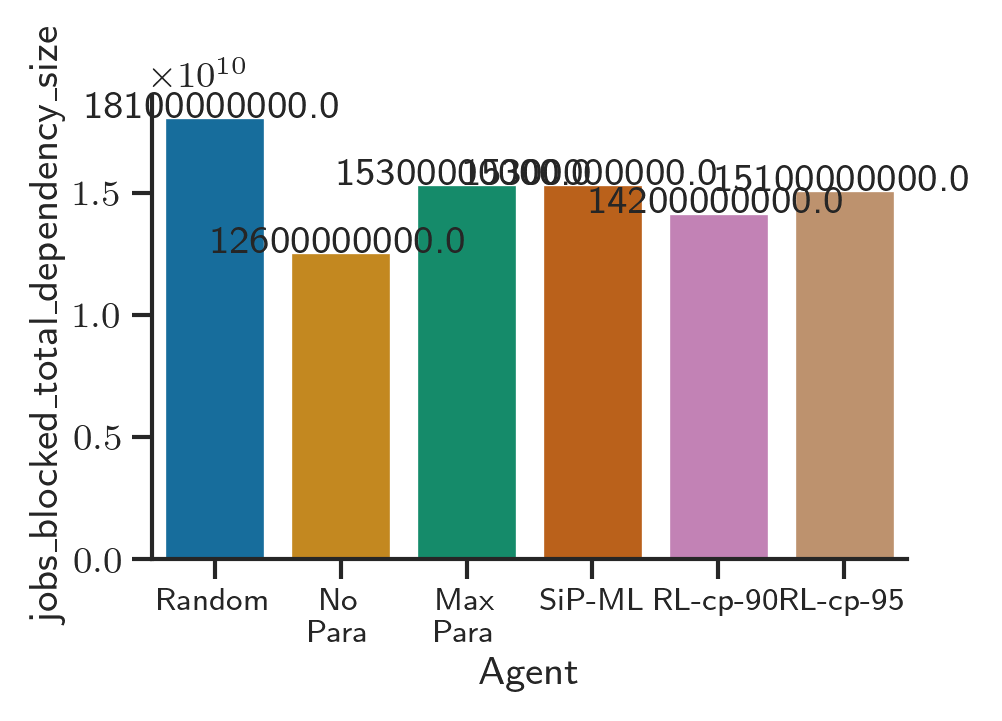

Plotting metric jobs_blocked_total_operation_memory_cost -> min=13155212196.0 | max=17552143312.484848 | mean=14978874571.43379


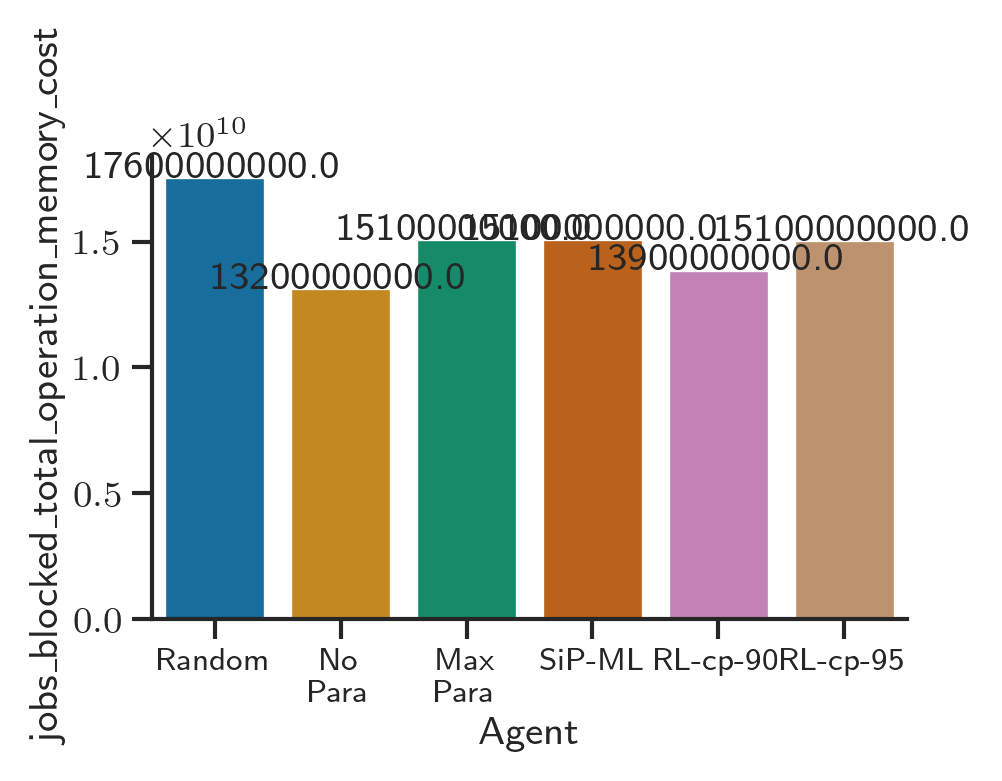



STEP METRICS
Plotting metric mean_cluster_throughput -> min=1391644.6392974767 | max=97700679.87908456 | mean=33661919.72836549


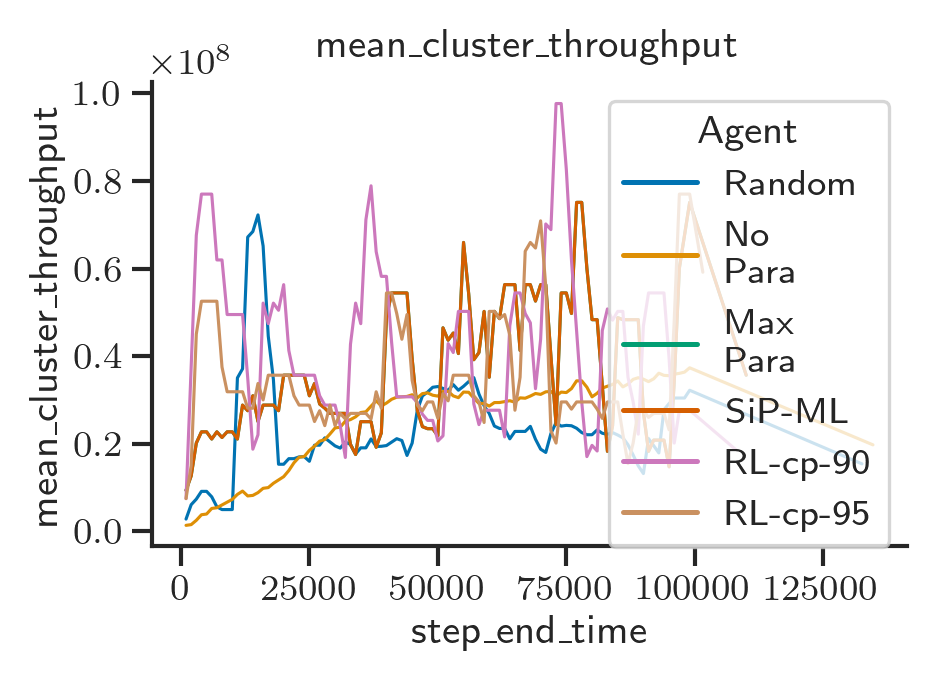

Plotting metric mean_num_mounted_workers -> min=1.0 | max=32.0 | mean=25.273333333333333


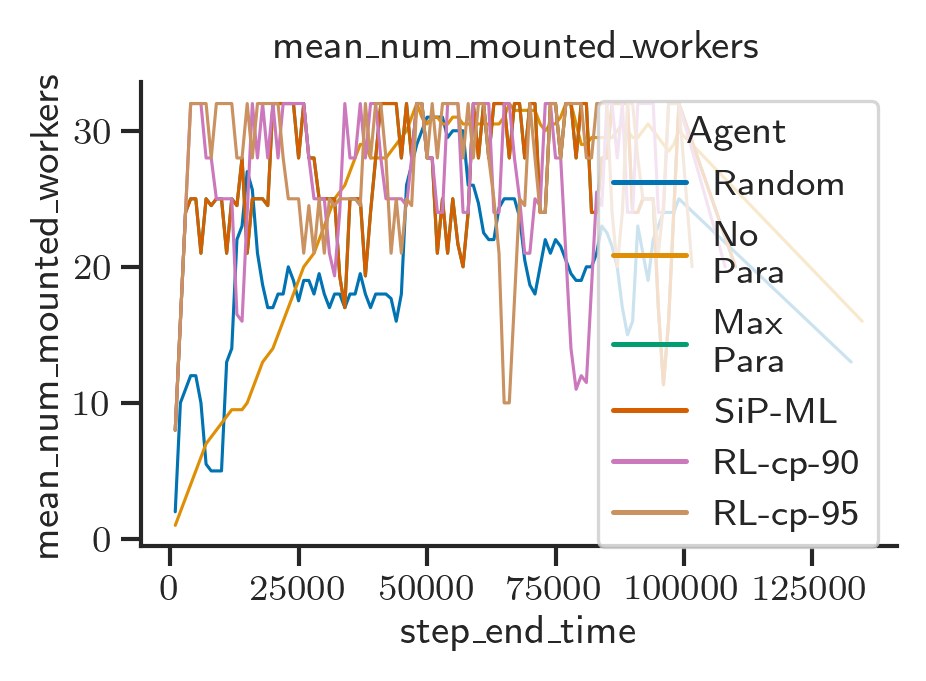

Plotting metric mean_comm_overhead_frac -> min=0.8554968864092007 | max=1.0 | mean=0.979038174937676


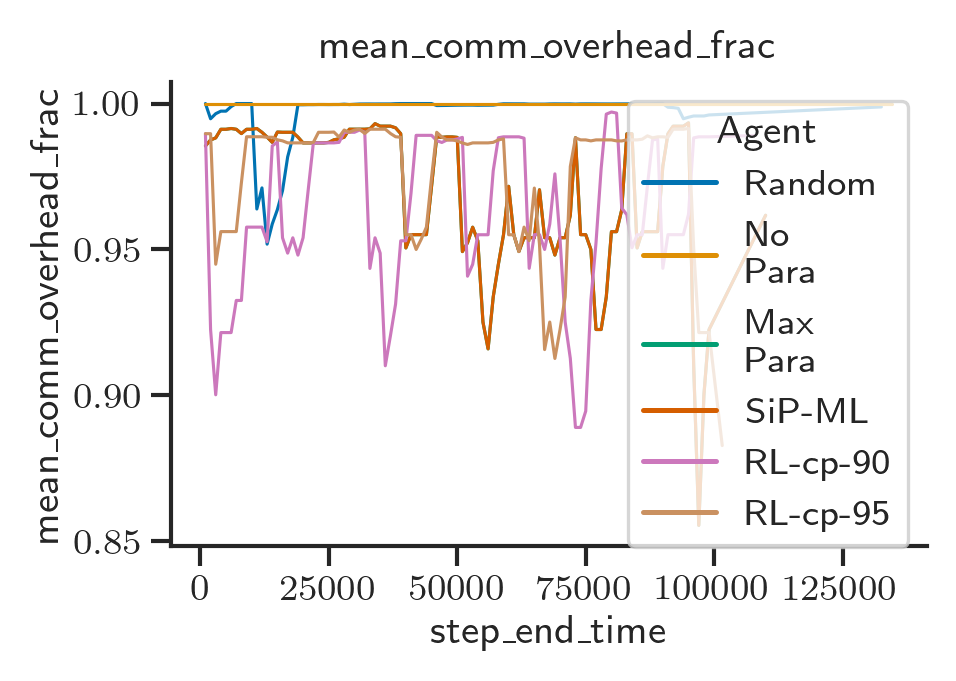

Plotting metric num_jobs_arrived -> min=0 | max=1 | mean=0.99


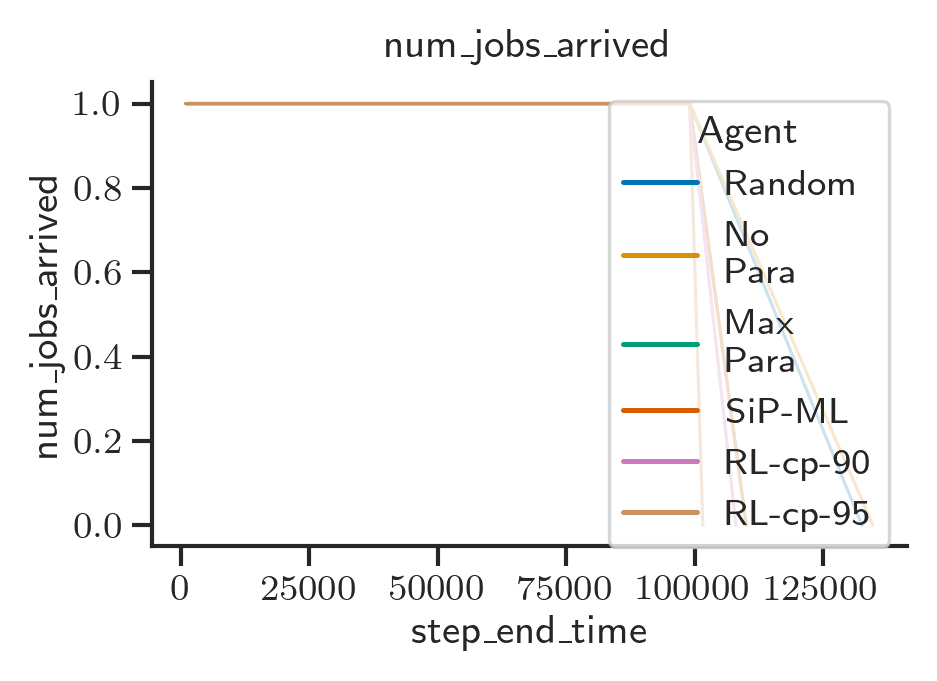

Plotting metric mean_mounted_worker_utilisation_frac -> min=0.35712865422279755 | max=1.0000000000000004 | mean=0.683543894468518


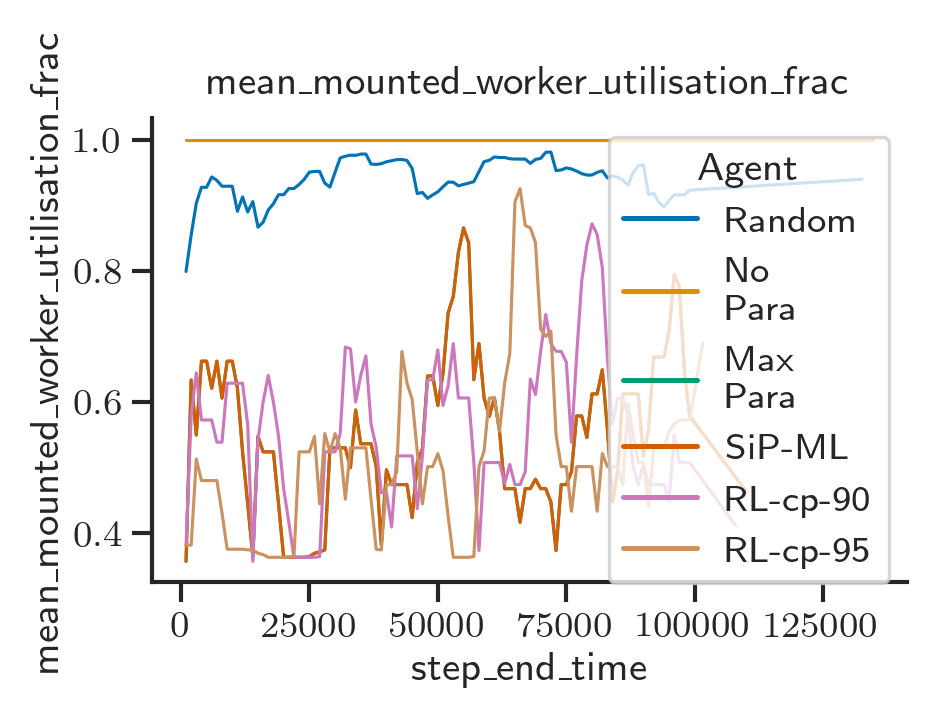

Plotting metric mean_compute_throughput -> min=656908.5330452644 | max=18272787.2752884 | mean=8321278.814585517


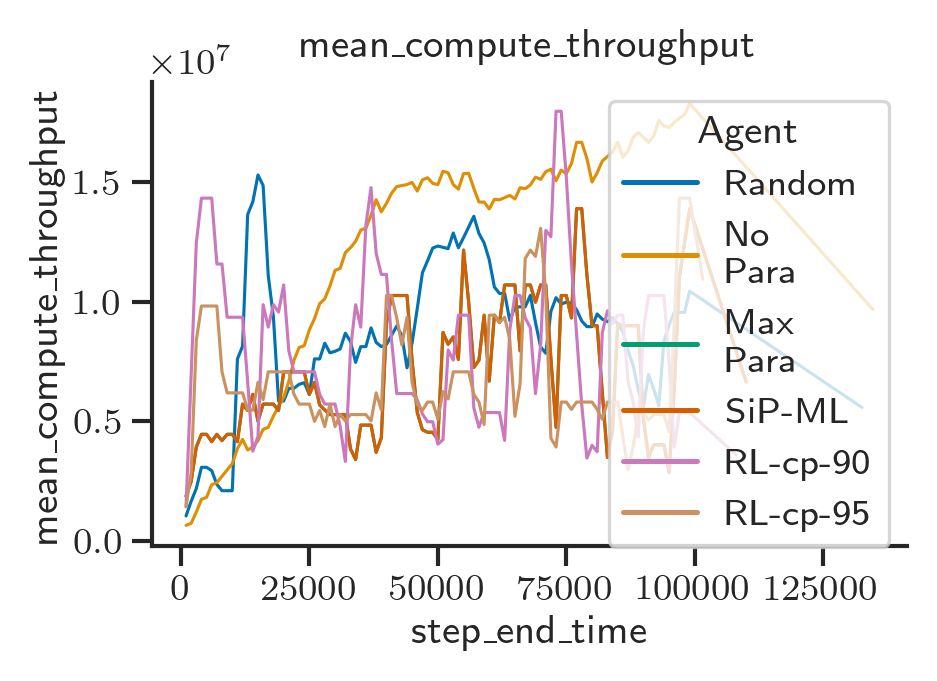

Plotting metric compute_info_processed -> min=656908533.0452645 | max=310542015129.7974 | mean=9197000218.159994


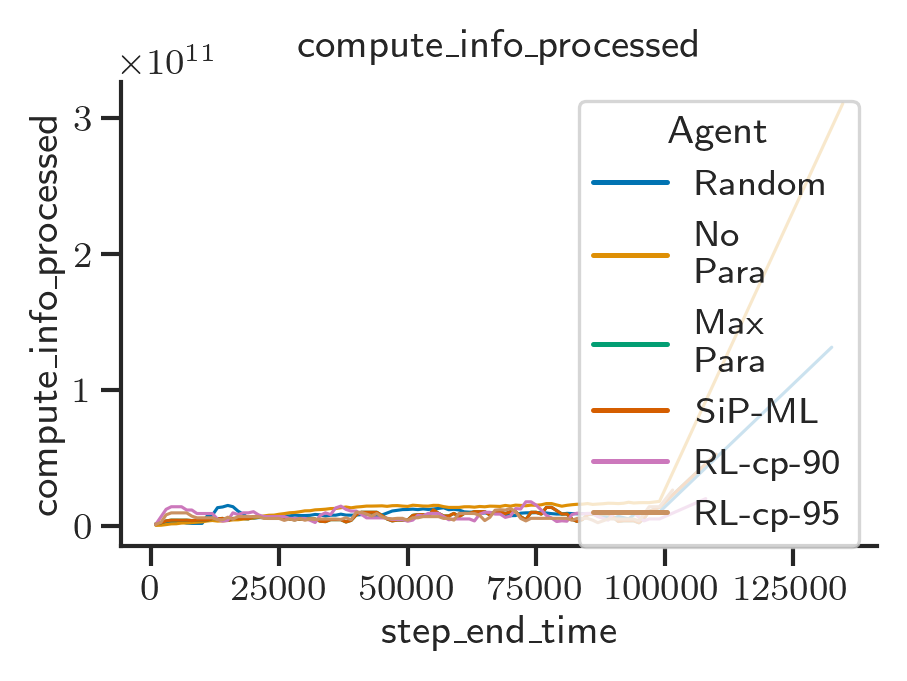

Plotting metric step_end_time -> min=1000.0 | max=134668.35000000003 | mean=50661.28928271193


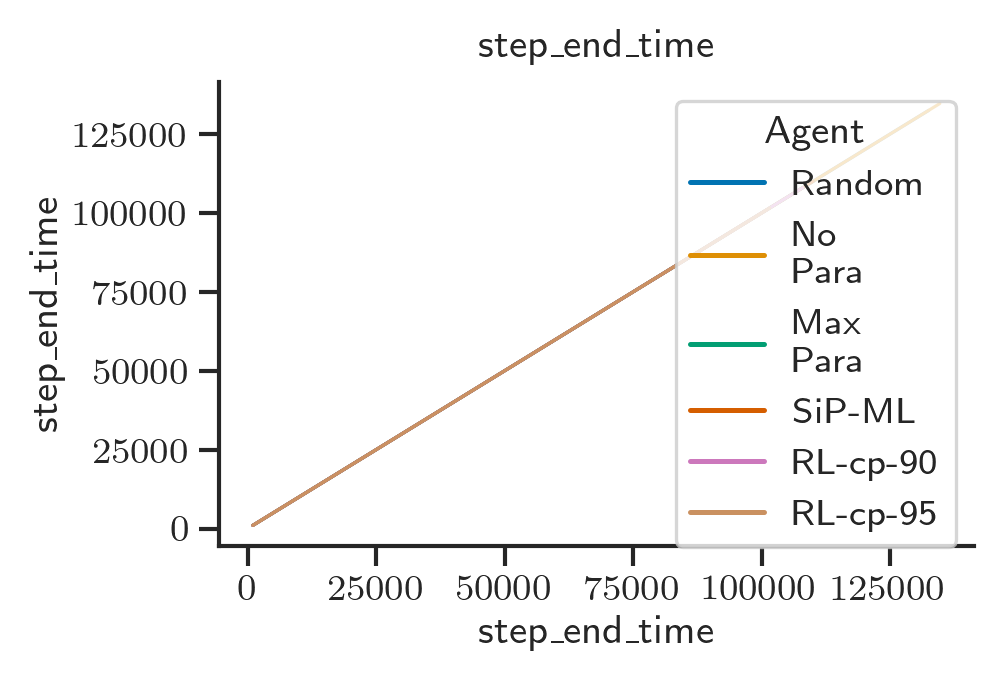

Plotting metric comm_info_processed -> min=734736106.2522124 | max=324325870859.51874 | mean=26934054501.93999


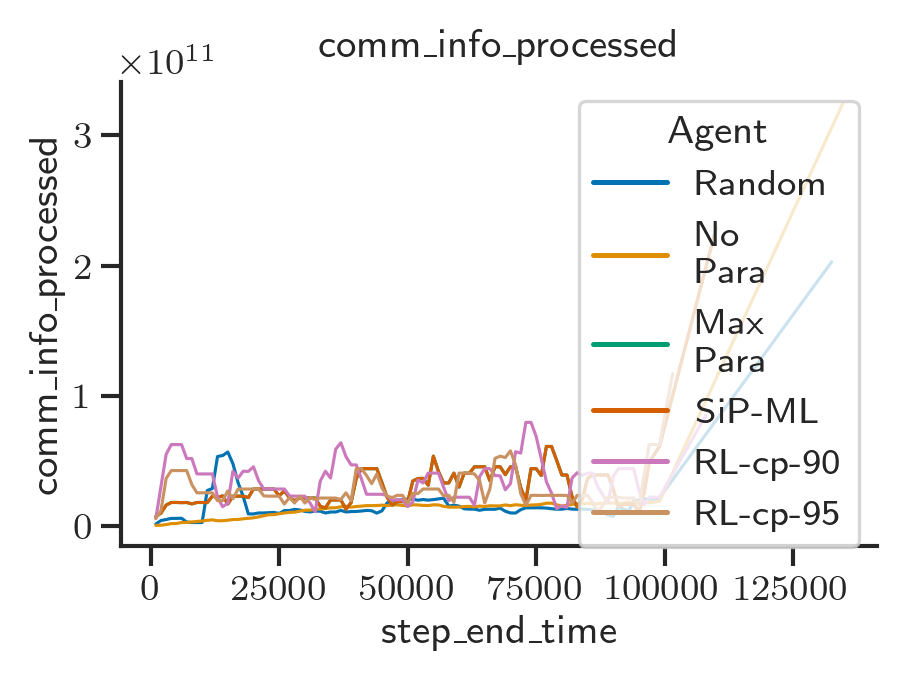

Plotting metric mean_comm_throughput -> min=734736.1062522124 | max=79749882.73104082 | mean=25340640.91377997


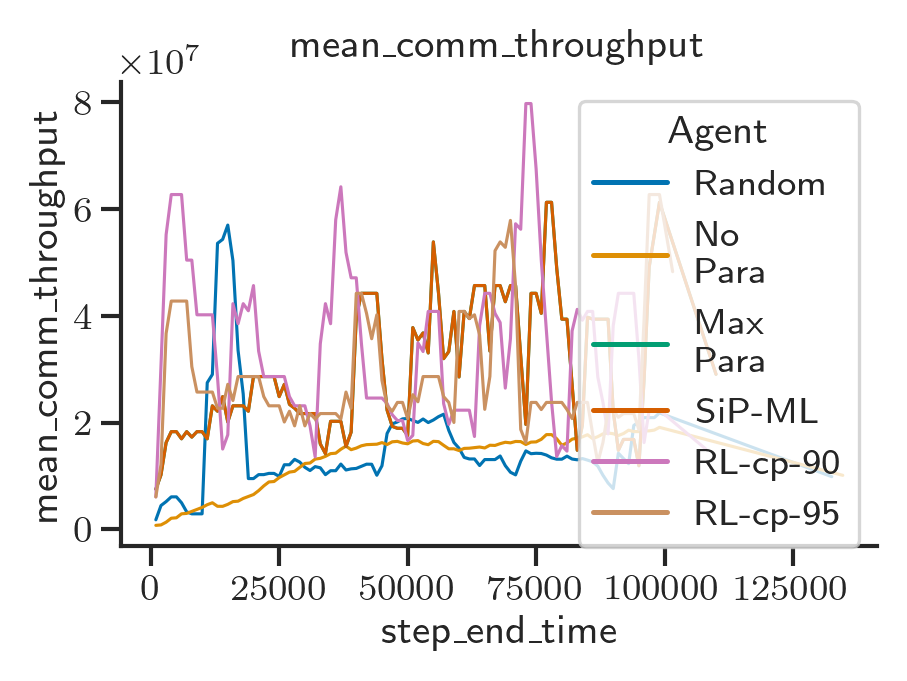

Plotting metric mean_cluster_worker_utilisation_frac -> min=0.031250000000000014 | max=0.9999999999999998 | mean=0.5221253808673582


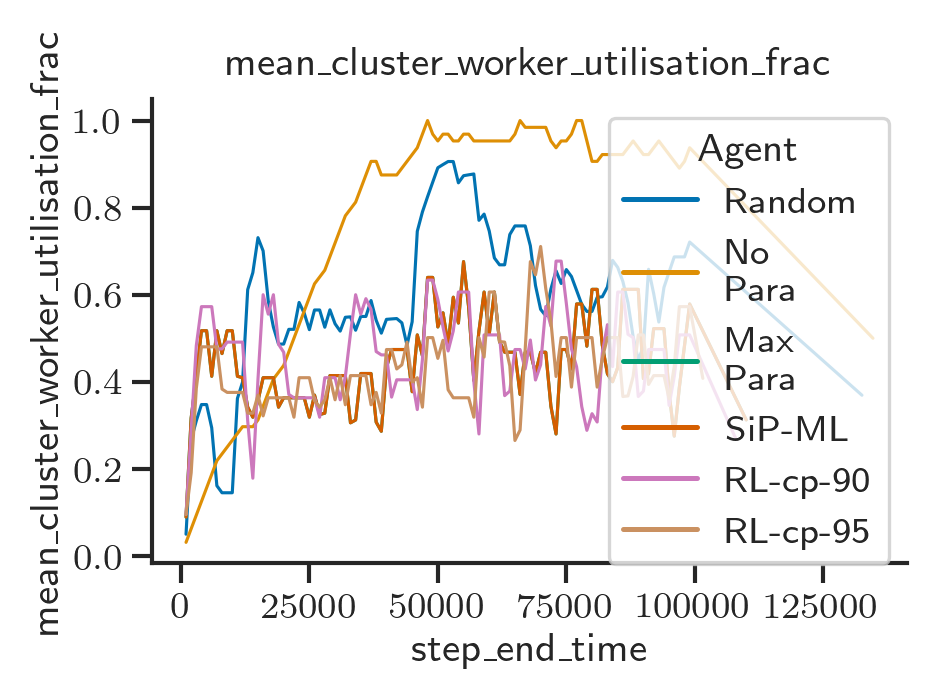

Plotting metric cluster_info_processed -> min=1391644639.2974768 | max=634867885989.3162 | mean=36131054720.09998


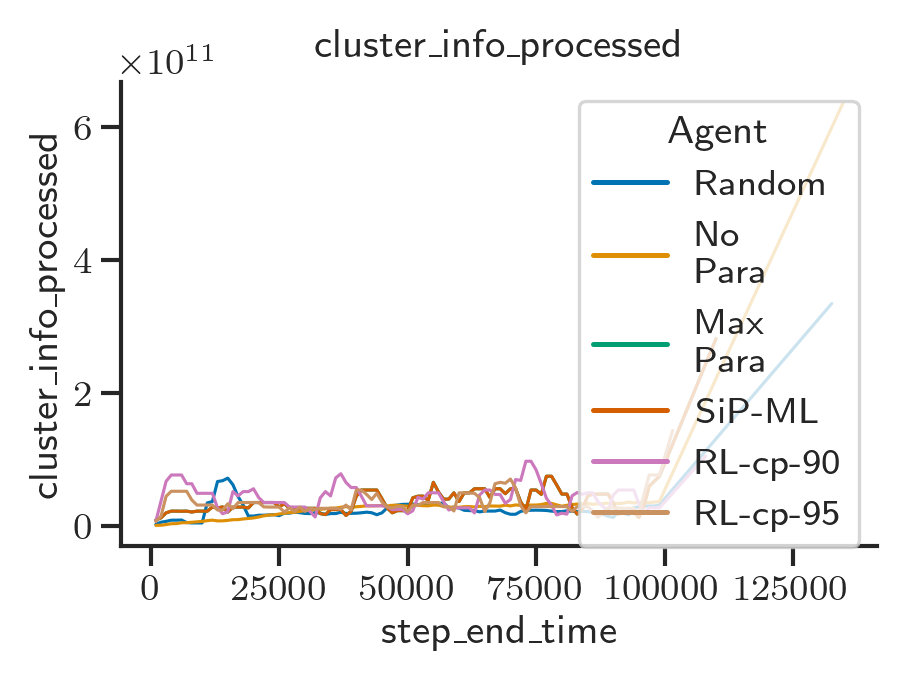

Plotting metric num_jobs_completed -> min=0 | max=31 | mean=0.5733333333333334


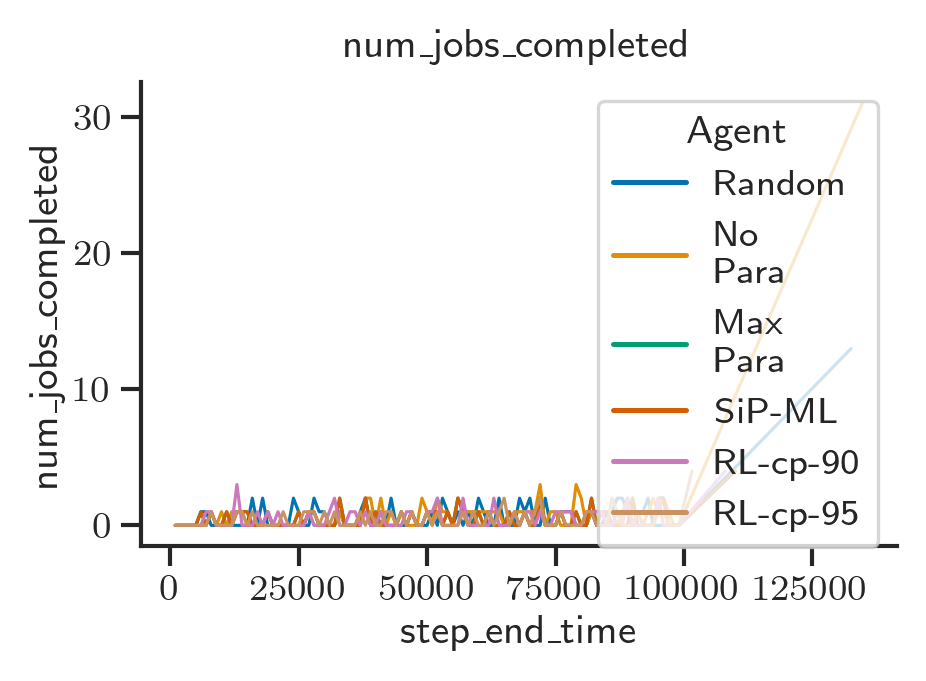

Plotting metric mean_compute_overhead_frac -> min=1.0 | max=1.0 | mean=1.0


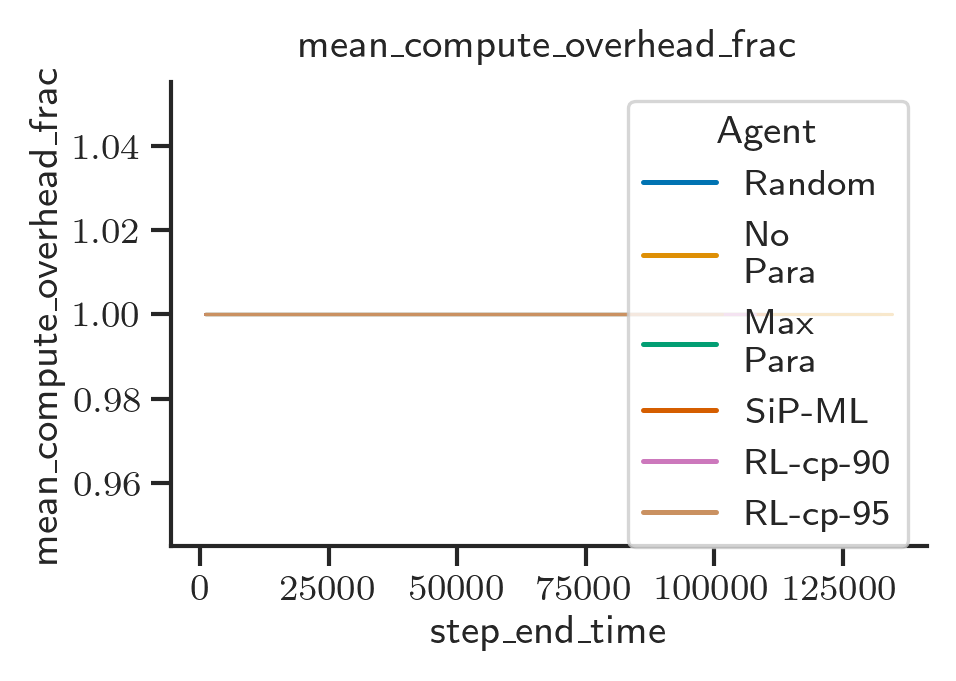

Plotting metric mean_num_mounted_channels -> min=0.0 | max=224.0 | mean=129.8574358974359


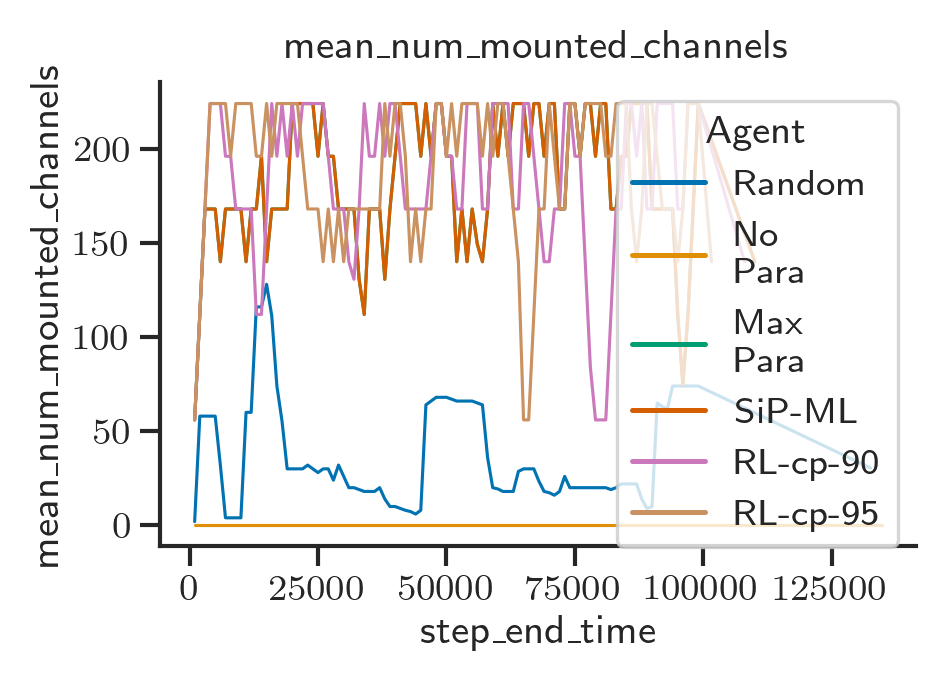

Plotting metric reward -> min=6.975151051070205e-06 | max=0.0004896918226860632 | mean=0.00017818874868127222


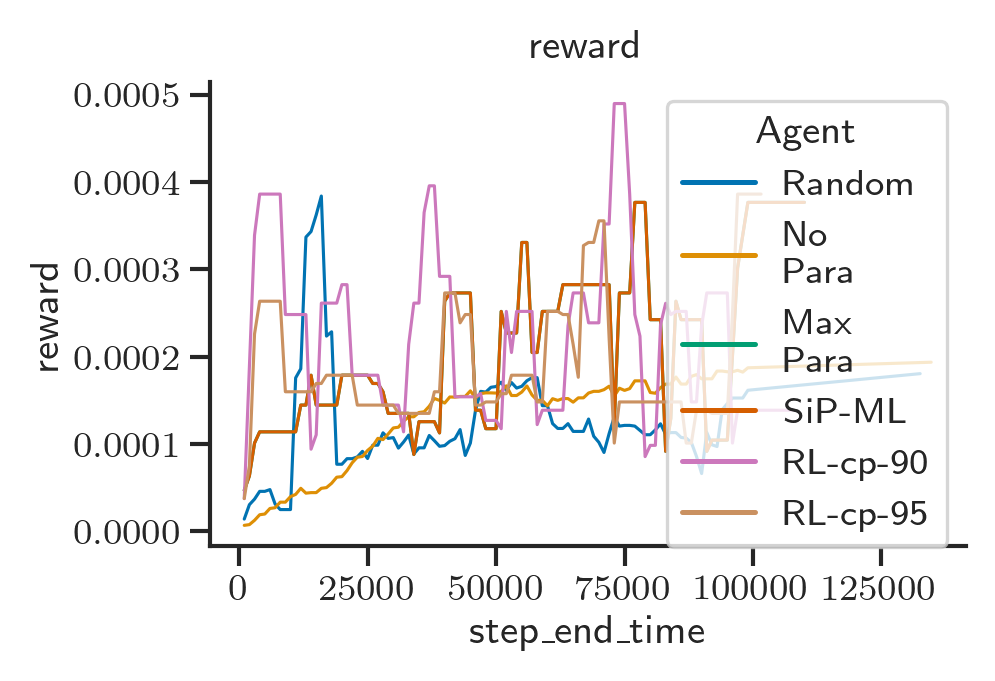

Plotting metric mean_num_jobs_running -> min=1.0 | max=32.0 | mean=8.42


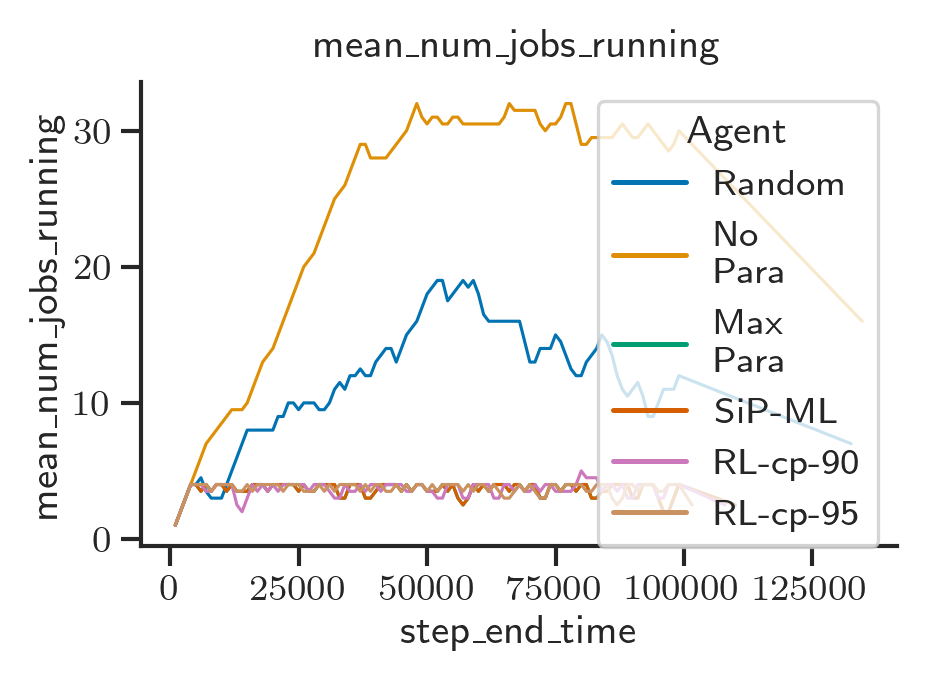

Plotting metric num_jobs_blocked -> min=0 | max=1 | mean=0.4266666666666667


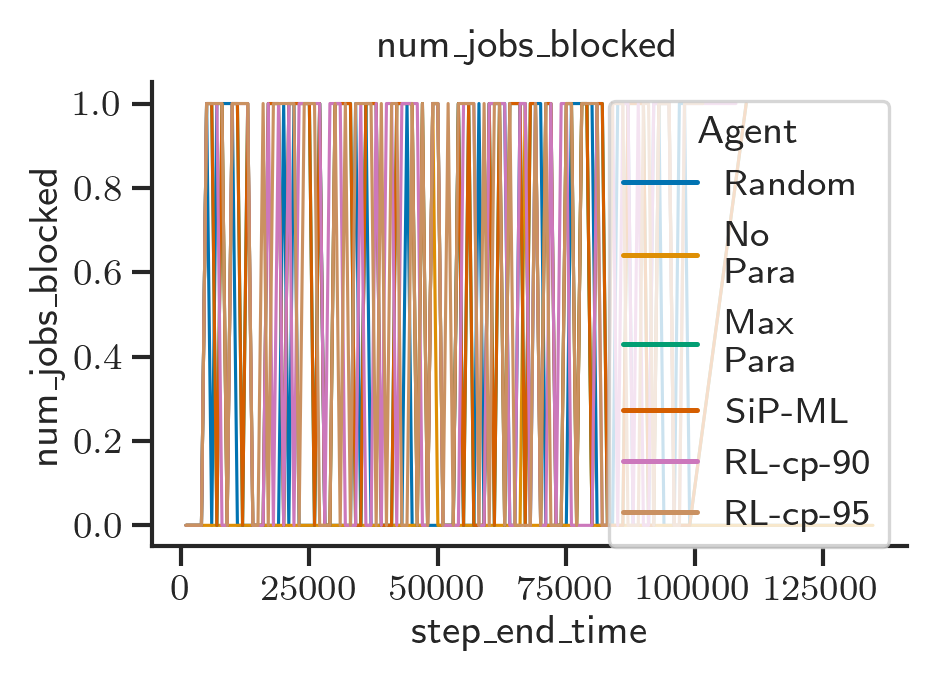

Plotting metric step_start_time -> min=0.0 | max=99000.0 | mean=49500.0


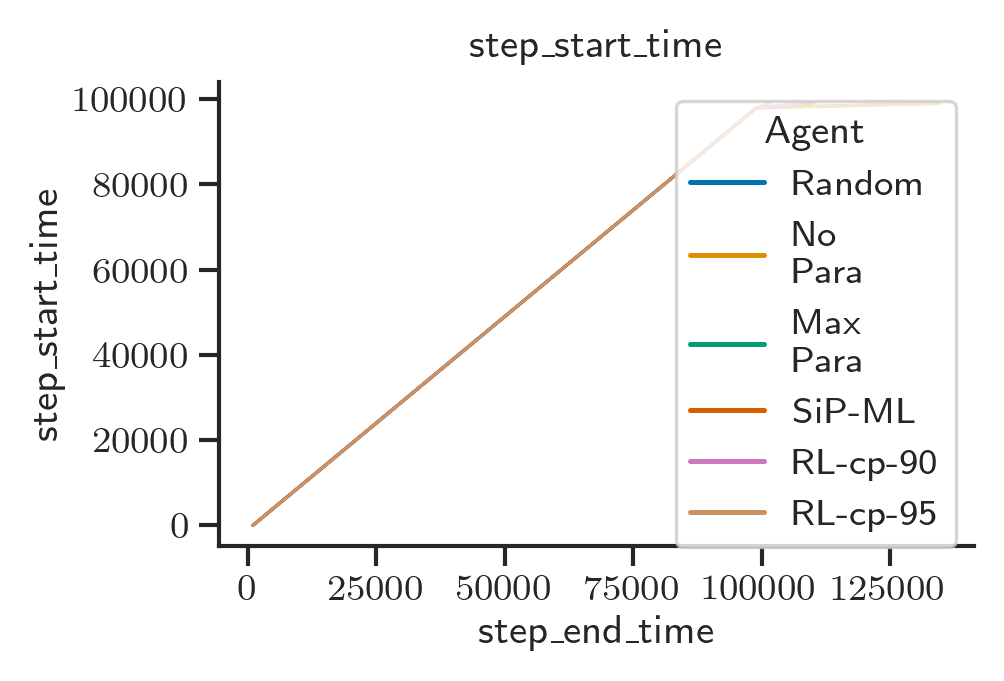

Plotting metric step_counter -> min=0 | max=194 | mean=70.8


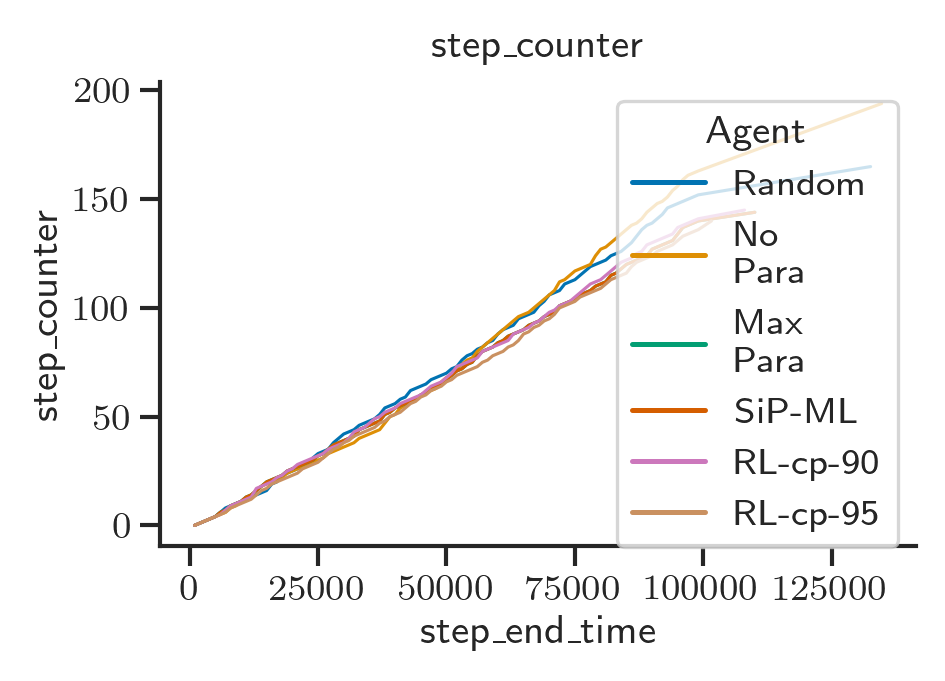

Plotting metric job_queue_length -> min=0 | max=1 | mean=0.99


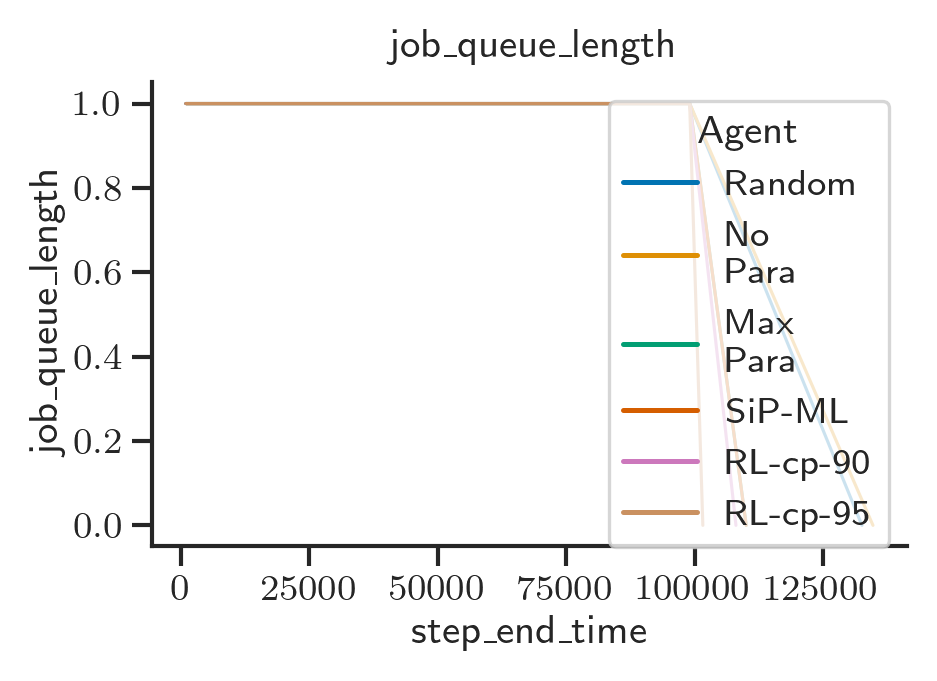

Plotting metric action -> min=0 | max=8 | mean=3.915


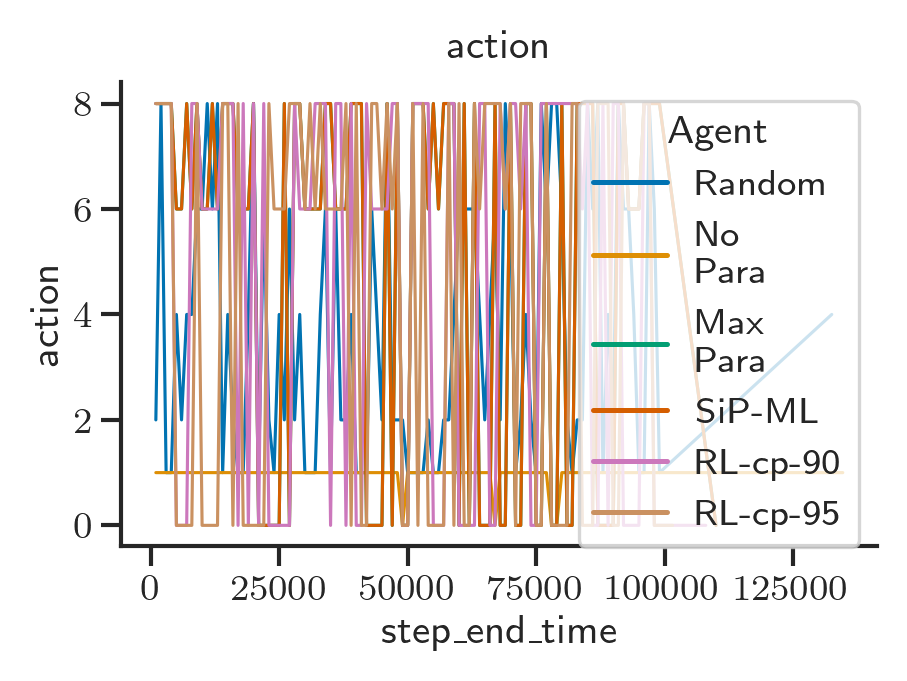

In [146]:
print(f'\n\nEPISODE METRICS')
for metric in episode_metrics:
    barplot(df=episode_stats_df, metric=metric, display_values=display_values)
if len(episode_completion_stats_df) > 0:
    for metric in episode_completion_metrics:
        barplot(df=episode_completion_stats_df, metric=metric)
if len(episode_blocked_stats_df) > 0:
    for metric in episode_blocked_metrics:
        barplot(df=episode_blocked_stats_df, metric=metric)
    
print(f'\n\nSTEP METRICS')
for metric in step_metrics:
    lineplot(df=step_stats_df, metric=metric)

$r = - \bigg[ \frac{C_{j^{a}}}{C_{j^{s}}} \cdot \beta_{1} + \alpha \cdot \bigg( \frac{ C_{{j}^{s}} - C_{J^{s}_{min}} }{ C_{J^{s}_{min}} - C_{{J}^{s}_{max}}} + 1 \bigg) \cdot \beta_{2} \bigg]$

- $r$ $\rightarrow$ Per-step reward
- $C_{j}^{a/s} \in \mathbb{R}$ $\rightarrow$ Per-job actual/sequential completion time
- $C_{J_{min/max}^{s}} \in \mathbb{R}$ $\rightarrow$ Min/max sequential completion time across all jobs in simulation
- $\beta_{1} \in {0, 1} $ $\rightarrow$ $0$ if job blocked, $1$ if accepted
- $\beta_{2} \in {0, 1} $ $\rightarrow$ $1$ if job blocked, $0$ if accepted
- $\alpha \in \mathbb{R}$ $\rightarrow$ Blocking weight (higher $\rightarrow$ prioritise minimising blocking, lower $\rightarrow$ prioritise minimising completion time)